In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

In [6]:
df = pd.read_csv("titanic/Train.csv")

# Exploratory Data Analysis (EDA)
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


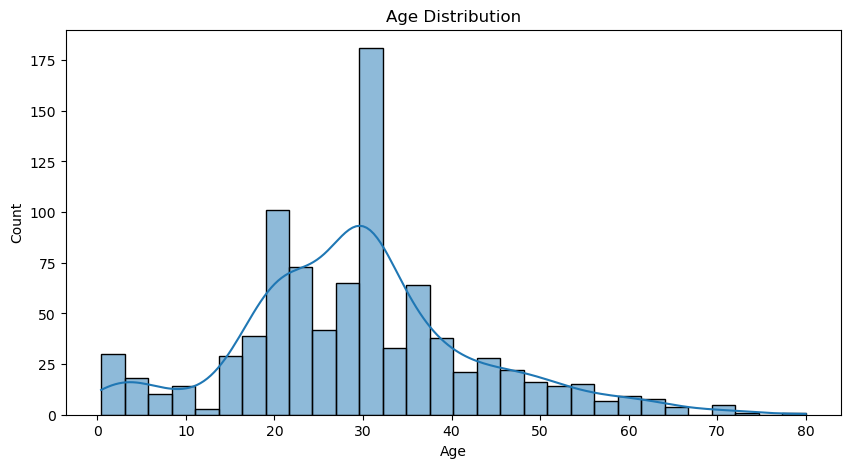

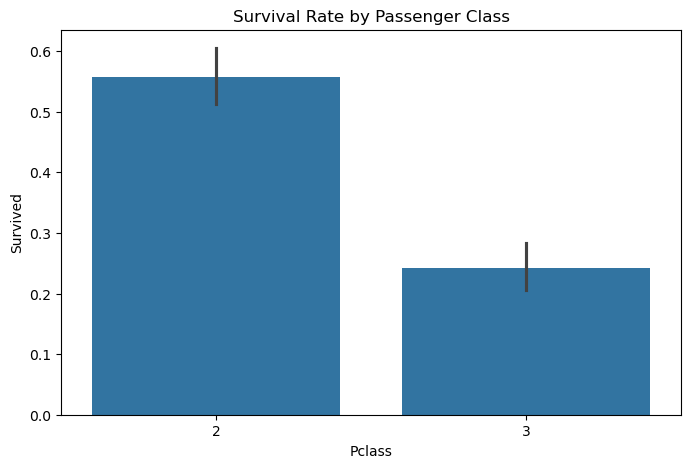

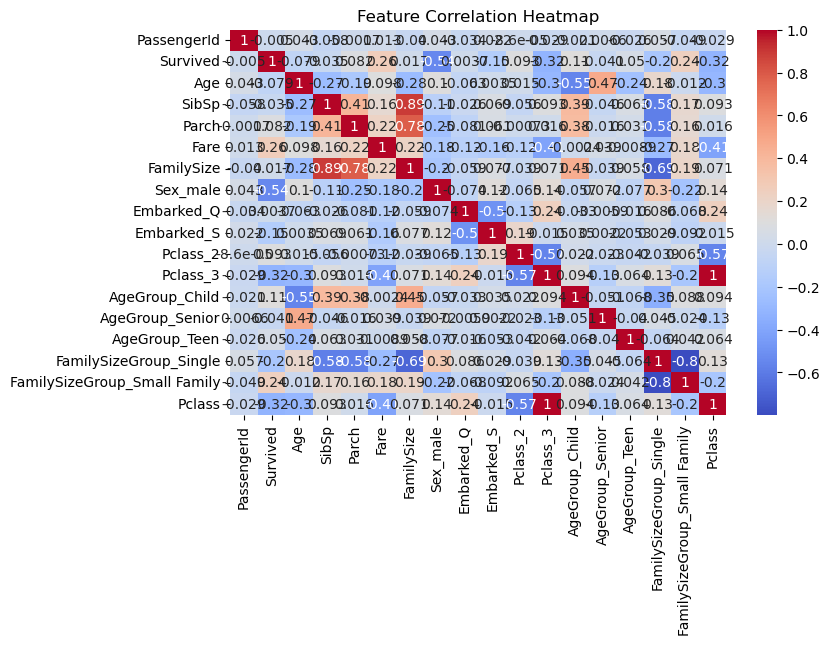

In [23]:
 #Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.show()
df['Pclass'] = df[['Pclass_2', 'Pclass_3']].idxmax(axis=1).map({'Pclass_2': 2, 'Pclass_3': 3}).fillna(1)

plt.figure(figsize=(8, 5))
sns.barplot(x='Pclass', y='Survived', data=df, estimator=np.mean)

plt.title('Survival Rate by Passenger Class')
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [36]:


# Fill missing Age values with median Age
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing Fare values with median Fare of respective Pclass
df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('median'))

# Fill missing Embarked_S values (assuming Embarked_C was dropped)
df['Embarked_S'] = df['Embarked_S'].fillna(0)  # If missing, assume not embarked at 'S'

# Reconstruct 'Embarked' category based on available 'Embarked_S' column
df['Embarked'] = df['Embarked_S'].map({1: 'S', 0: 'C'})  # Assume missing as 'C'

# Convert 'Embarked' back to one-hot encoding
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Print final column names to verify
print("Final Columns after preprocessing:", df.columns)


Final Columns after preprocessing: Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_male', 'Pclass_2', 'Pclass_3', 'AgeGroup_Child',
       'AgeGroup_Senior', 'AgeGroup_Teen', 'FamilySizeGroup_Single',
       'FamilySizeGroup_Small Family', 'Pclass', 'Embarked_S'],
      dtype='object')


In [14]:
# Feature Engineering
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

def categorize_age(age):
    if age < 12:
        return 'Child'
    elif age < 18:
        return 'Teen'
    elif age < 60:
        return 'Adult'
    else:
        return 'Senior'

df['AgeGroup'] = df['Age'].map(categorize_age)

def categorize_family(size):
    if size == 1:
        return 'Single'
    elif size <= 3:
        return 'Small Family'
    else:
        return 'Large Family'

df['FamilySizeGroup'] = df['FamilySize'].map(categorize_family)


Model Accuracy: 0.7933


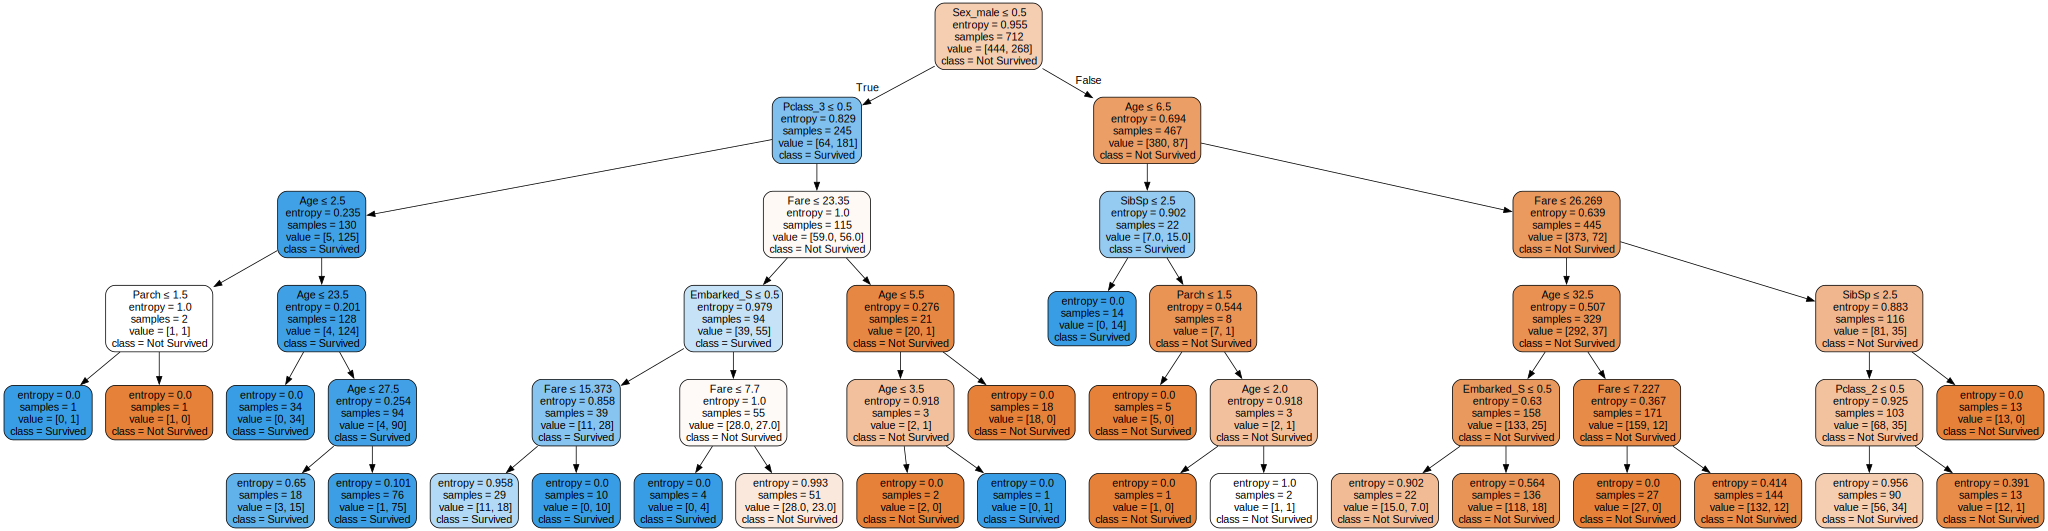

In [9]:
import pandas as pd
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

# One-Hot Encode categorical columns and drop unnecessary columns
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

# Drop columns that are not useful for prediction
df = df.drop(columns=['Name', 'Ticket', 'Cabin'], errors='ignore')

# Prepare data for model training
y = df['Survived']
X = df.drop(columns=['Survived', 'PassengerId'])  # Remove target and ID column

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Visualizing the Decision Tree
dot_data = export_graphviz(dt_model, out_file=None, feature_names=X.columns, 
                           class_names=['Not Survived', 'Survived'],
                           filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("titanic_tree")  # Saves the tree visualization as "titanic_tree.pdf"
graph


In [7]:
print(df.dtypes)


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
